In [ ]:
# Crop_Yield_Predictor_Final_Cleaned.ipynb

# 🧪 1. Setup & Data Loading
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare cleaned dataset
df = pd.read_csv("Crop_Yield_Predictor_Merged_Cleaned.csv")
df = df[df["Crop"] != "Sugarcane"]  # Remove outlier crop
df.fillna(df.mean(numeric_only=True), inplace=True)

In [ ]:
# 🧼 2. Feature Engineering
# Create efficiency metric
df["Efficiency (tonnes/ha)"] = df["Production (metric tonnes)"] / df["Area (ha)"]
df["Fertilizer per ha"] = df["Fertilizer Used (kg)"] / df["Area (ha)"]
df["Fertilizer Used (tonnes)"] = df["Fertilizer Used (kg)"] / 1000
df["Pesticide Used (tonnes)"] = df["Pesticide Used (kg)"] / 1000
df["Pesticide per ha"] = df["Pesticide Used (kg)"] / df["Area (ha)"]
df["Pesticide per ha (tonnes)"] = (df["Pesticide Used (kg)"] / 1000) / df["Area (ha)"]

# Top 10 crops by frequency
top_10_crops = df["Crop"].value_counts().nlargest(10).index.tolist()
df = df[df["Crop"].isin(top_10_crops)]
top_10_states = df["State"].value_counts().nlargest(10).index.tolist()
df_top_states = df[df["State"].isin(top_10_states)]
# Feature Engineering
df["Pesticide Used (tonnes)"] = df["Pesticide Used (kg)"] / 1000
df["Pesticide per ha"] = df["Pesticide Used (tonnes)"] / df["Area (ha)"]

# Filter to top 10 states
top_states = df["State"].value_counts().nlargest(10).index.tolist()
df_top_states = df[df["State"].isin(top_states)]

In [ ]:
print(df_top_states.columns.tolist())

['Crop', 'Crop_Year', 'Season', 'State', 'Area (ha)', 'Production (metric tonnes)', 'Annual Rainfall (mm)', 'Fertilizer Used (kg)', 'Pesticide Used (kg)', 'Yield (tonnes/ha)', 'Fertilizer_per_Ha', 'Monsoon_Rainfall', 'Efficiency (tonnes/ha)', 'Fertilizer per ha', 'Fertilizer Used (tonnes)', 'Pesticide Used (tonnes)', 'Pesticide per ha', 'Pesticide per ha (tonnes)']


<ipython-input-32-f46722639d36>:28: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


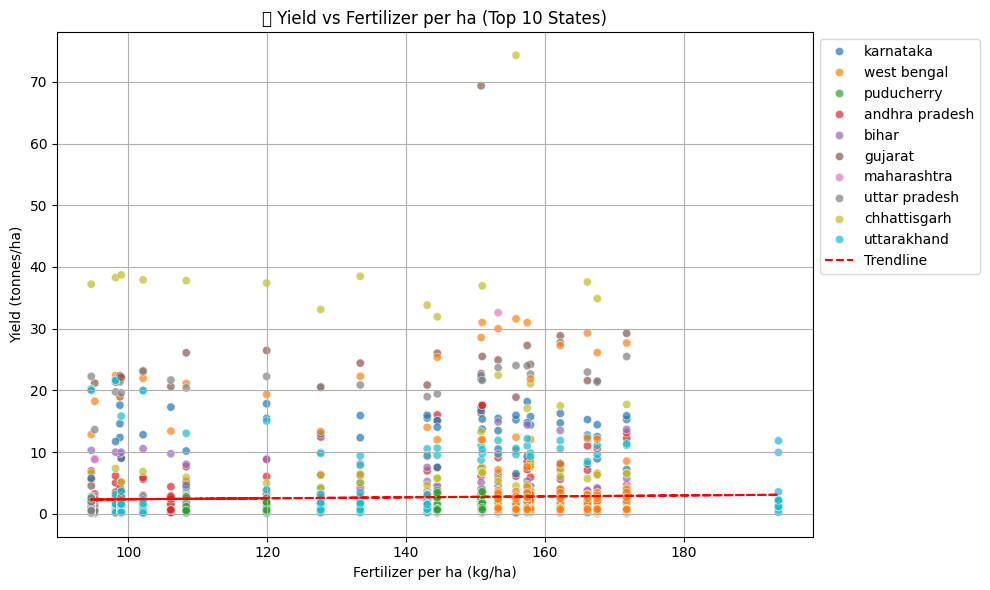

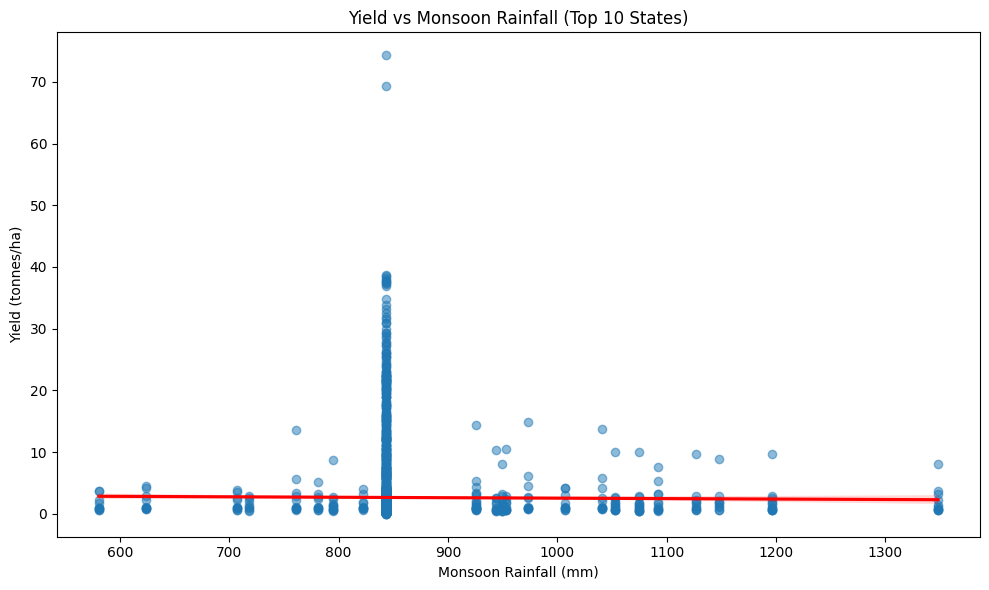

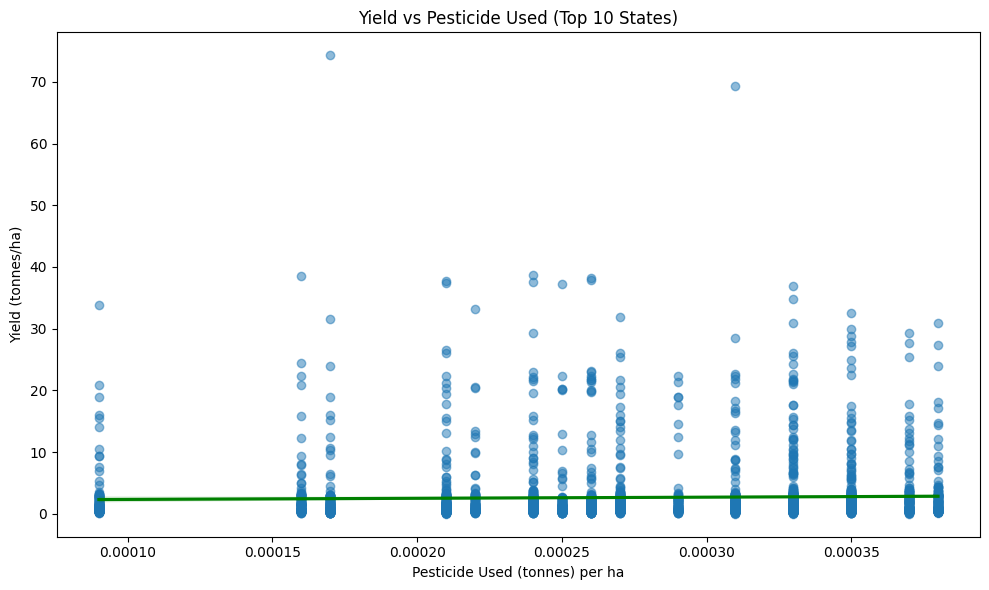

In [ ]:
# 📊 3. Visualizations (Feature Relationships)
# Recalculate using the correct fertilizer column
df["Fertilizer per ha"] = df["Fertilizer Used (kg)"] / df["Area (ha)"]

# Filter for top 10 states
df_top_states = df[df["State"].isin(top_10_states)]

# Plotting with updated data
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_top_states,
    x="Fertilizer per ha",
    y="Yield (tonnes/ha)",
    hue="State",
    alpha=0.7
)

# Add trendline
z = np.polyfit(df_top_states["Fertilizer per ha"], df_top_states["Yield (tonnes/ha)"], 1)
p = np.poly1d(z)
plt.plot(df_top_states["Fertilizer per ha"], p(df_top_states["Fertilizer per ha"]), "r--", label="Trendline")

plt.title("📈 Yield vs Fertilizer per ha (Top 10 States)")
plt.xlabel("Fertilizer per ha (kg/ha)")
plt.ylabel("Yield (tonnes/ha)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

#yield vs rainfall during monsoon season
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df_top_states,
    x="Monsoon_Rainfall",
    y="Yield (tonnes/ha)",
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
plt.title("Yield vs Monsoon Rainfall (Top 10 States)")
plt.xlabel("Monsoon Rainfall (mm)")
plt.ylabel("Yield (tonnes/ha)")
plt.tight_layout()
plt.show()

#yield vs pesticide use
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df_top_states,
    x="Pesticide per ha",
    y="Yield (tonnes/ha)",
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "green"}
)
plt.title("Yield vs Pesticide Used (Top 10 States)")
plt.xlabel("Pesticide Used (tonnes) per ha")
plt.ylabel("Yield (tonnes/ha)")
plt.tight_layout()
plt.show()


In [ ]:
# 📈 4. Model Training (XGBoost)
# For those unfamiliar with machine learning: here we use a model called XGBoost, which is good at identifying complex patterns in data. We're training it to learn the relationship between features (like crop type, season, fertilizer use, etc.) and the target value — crop yield in tonnes per hectare.

# Once trained, the model can estimate what the yield might be under similar conditions in the future, helping farmers or agri-tech companies make informed decisions.

# The performance of the model is evaluated using:
# - MAE (Mean Absolute Error): the average difference between predicted and actual values. Lower is better.
# - RMSE (Root Mean Squared Error): gives more weight to large errors.
# - R² Score: shows how much of the yield variation the model can explain (1.0 is perfect).

X = df.drop(columns=["Yield (tonnes/ha)"])
y = df["Yield (tonnes/ha)"]

# One-hot encode categoricals
X = pd.get_dummies(X, columns=["Crop", "Season", "State"], drop_first=True)

# Split
df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(df_train, y_train)
y_pred = model.predict(df_test)

In [ ]:
# 📏 5. Evaluation
mae = mean_absolute_error(y_test, y_pred)
# Calculate RMSE without the 'squared' argument, then take the square root
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📉 MAE: {mae:.2f}")
print(f"📉 RMSE: {rmse:.2f}")
print(f"📈 R² Score: {r2:.4f}")

📉 MAE: 0.29
📉 RMSE: 1.58
📈 R² Score: 0.8973


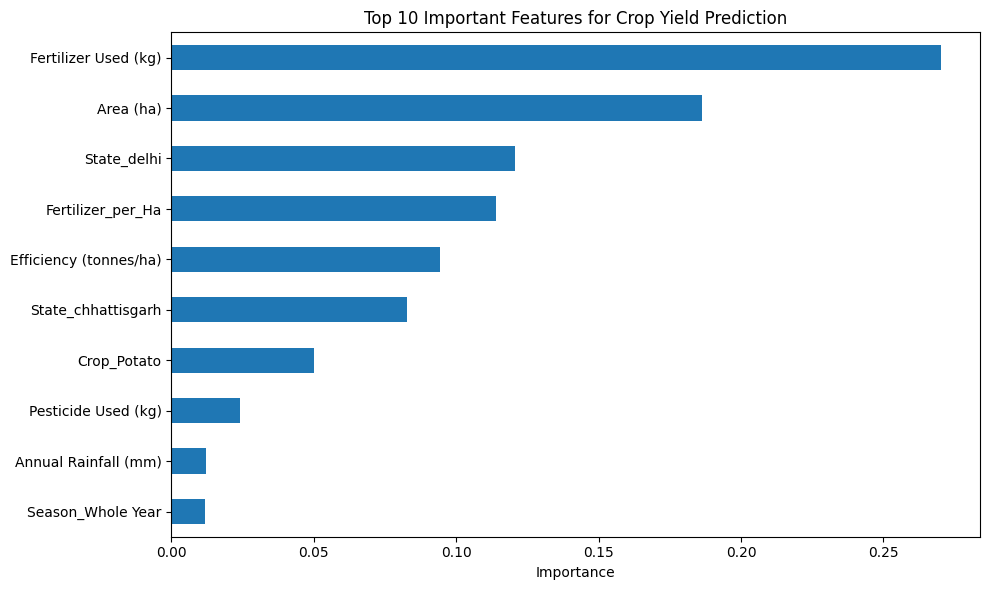

In [ ]:
# 🔍 6. Feature Importances
importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_features.plot(kind="barh")
plt.title("Top 10 Important Features for Crop Yield Prediction")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# 📅 7. Example Prediction: Future Year Scenario
# Predict rice yield in 2024 for a known state with average features
sample = df[df["Crop"] == "Rice"].iloc[0].copy()
sample["Crop Year"] = 2024
sample["Monsoon_Rainfall"] = df[df["Crop"] == "Rice"]["Monsoon_Rainfall"].mean()
sample["Fertilizer Used (kg)"] = df[df["Crop"] == "Rice"]["Fertilizer Used (kg)"].mean()
sample["Pesticide Used (kg)"] = df[df["Crop"] == "Rice"]["Pesticide Used (kg)"].mean()

# Remove target and re-encode
sample = sample.drop("Yield (tonnes/ha)", errors="ignore")
sample_df = pd.DataFrame([sample])
sample_df = pd.get_dummies(sample_df, columns=["Crop", "Season", "State"], drop_first=True)

# Align columns
missing_cols = set(X.columns) - set(sample_df.columns)
for col in missing_cols:
    sample_df[col] = 0
sample_df = sample_df[X.columns]

future_yield = model.predict(sample_df)[0]
print(f"📍 Predicted Rice Yield (2024): {future_yield:.2f} tonnes/ha")

📍 Predicted Rice Yield (2024): 1.16 tonnes/ha
